In [1]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.integrate import solve_ivp

print(torch.cuda.is_available())
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "no gpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True
Tesla P100-PCIE-12GB


device(type='cuda')

In [2]:
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load simple ODE


In [3]:
def hysteresis_ode(t,x,lam):
    return lam+x-x**3

def simulate_branch(lam_values, x0):
    x_vals = []
    x_curr = x0
    for lam in tqdm(lam_values):
        sol = solve_ivp(hysteresis_ode, [0, 50], [x_curr], args=(lam,), t_eval=[50])
        x_curr = sol.y[0, -1]  # final value
        x_vals.append(x_curr)
    return np.array(x_vals)

In [4]:
lam_start = -1 
lam_end = 1

lam_up = np.linspace(lam_start, lam_end, 250)
lam_down = np.linspace(lam_end, lam_start, 250)

In [5]:
x0=-1
x_increase = simulate_branch(lam_up, x0)
x_decrease = simulate_branch(lam_down,x_increase[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

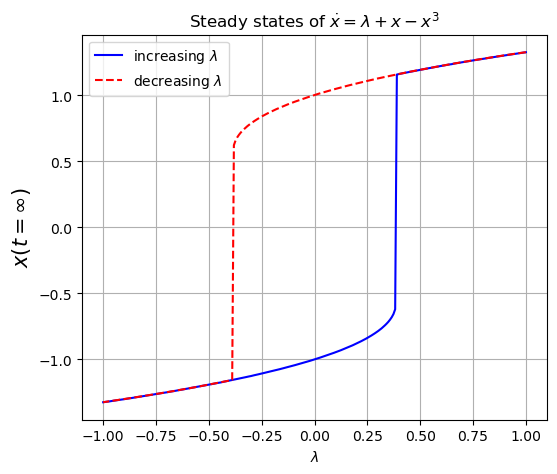

In [6]:

fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_up, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_down, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

In [7]:
X = np.hstack((x_increase, x_decrease))
X = np.hstack((X,X))

lam_vals  = np.hstack((lam_up,lam_down))
lam_vals = np.hstack((lam_vals,lam_vals))

t_train = np.arange(0,len(X),5)
X_train = X[t_train]
lam_train = lam_vals[t_train]

In [8]:
t_train.shape

(200,)

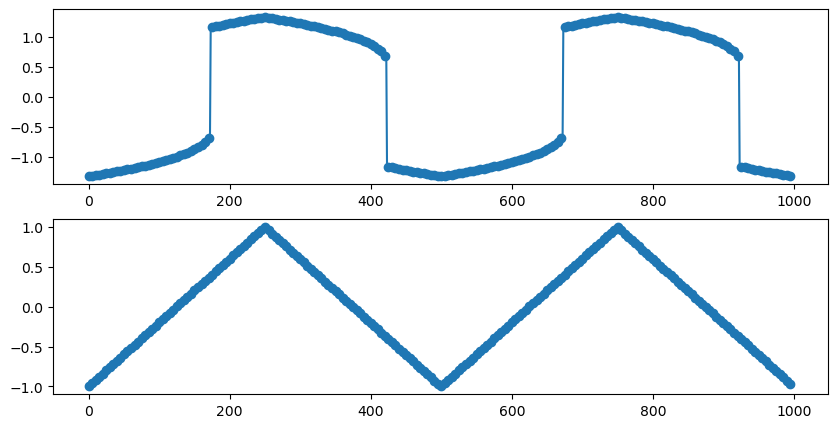

In [9]:
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(X)
ax[0].scatter(t_train,X_train)
ax[1].plot(lam_vals)
ax[1].scatter(t_train,lam_train)
plt.show()

# Neuro ODE approach

In [10]:
import numpy as np

import torch 
import torch.nn as nn
from torchdiffeq import odeint

In [11]:
def lam_func(t):
    lam_vals = np.hstack((lam_up,lam_down))
    idx = int(t) % len(lam_vals)
    return torch.tensor(lam_vals[idx], dtype=torch.float32, device=device)

In [12]:
class FTerm(nn.Module):
    def __init__(self,dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )
    def forward(self,x):
        return - torch.exp(self.network(x))


class GTerm(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )

    def forward(self, x, u):
        xu = torch.cat([x,u],dim=-1)
        return self.network(xu)


class ODEModel(nn.Module):
    def __init__(self,f,g):
        super().__init__()
        self.f = f
        self.g = g

    def forward(self, t, state, u_func):
        x = state
        u = u_func(t).unsqueeze(0).unsqueeze(1)
        fx = self.f(x)
        gx = self.g(x,u)
        return fx*(x-gx)

In [13]:

x_true = torch.tensor(X, dtype=torch.float32,device=device)
x0 = torch.tensor([[x_true[0]]],requires_grad = True, device=device)
dim_in = 1
dim_out = 1
f = FTerm(dim_in, dim_out).to(device)
g = GTerm(2, dim_out).to(device)

ode_model = ODEModel(f,g).to(device)


In [14]:
t_span = torch.arange(1000,dtype=torch.float32,device=device)

In [15]:
lam_func(t_span[0])

tensor(-1., device='cuda:0')

In [16]:
t0 = time.time()
# non-adaptive method is much faster
# see what is being used in neuromancer
method='rk4'
x_pred = odeint(lambda t, x: ode_model(t,x,lam_func),x0,t_span, method =method)
print(time.time()-t0)

5.090855121612549


In [17]:
x_pred.squeeze().shape, X.squeeze().shape

(torch.Size([1000]), (1000,))

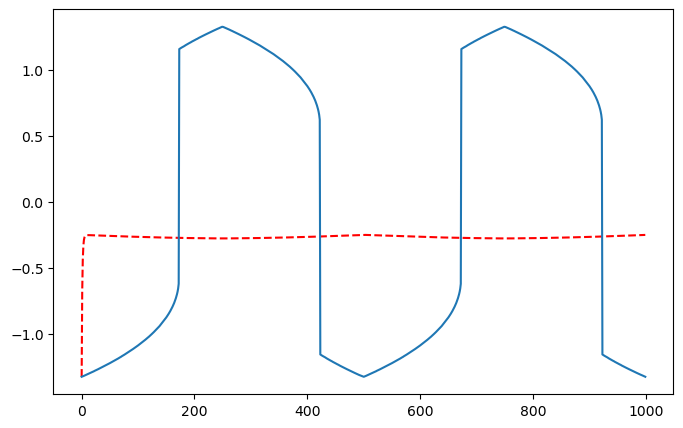

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red')
ax.plot(x_true.squeeze().detach().cpu().numpy(),)
plt.show()


In [19]:

x_true.shape

torch.Size([1000])

In [20]:
# about 46-1hr
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr=1e-1)
n_epochs = 10

for epoch in tqdm(range(n_epochs)):
    t1 = time.time()
    opt.zero_grad()
    x_pred = odeint(lambda t, x: ode_model(t,x,lam_func), x0, t_span)
    loss = loss_criteria(x_pred.squeeze(), x_true.squeeze())
    loss.backward()
    opt.step()
    t2 = time.time()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, time = {t2-t1} s.")
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Loss = 1.4121, time = 122.08270502090454 s.
Epoch 1: Loss = 1.1826, time = 368.67436623573303 s.
Epoch 2: Loss = 1.0572, time = 348.1124954223633 s.
Epoch 3: Loss = 0.9011, time = 353.30779337882996 s.
Epoch 4: Loss = 0.7140, time = 344.63064551353455 s.
Epoch 5: Loss = 0.5628, time = 326.25158977508545 s.
Epoch 6: Loss = 0.4958, time = 287.7804398536682 s.
Epoch 7: Loss = 0.4746, time = 246.25282502174377 s.
Epoch 8: Loss = 0.4605, time = 201.62113761901855 s.
Epoch 9: Loss = 0.4234, time = 160.31649446487427 s.


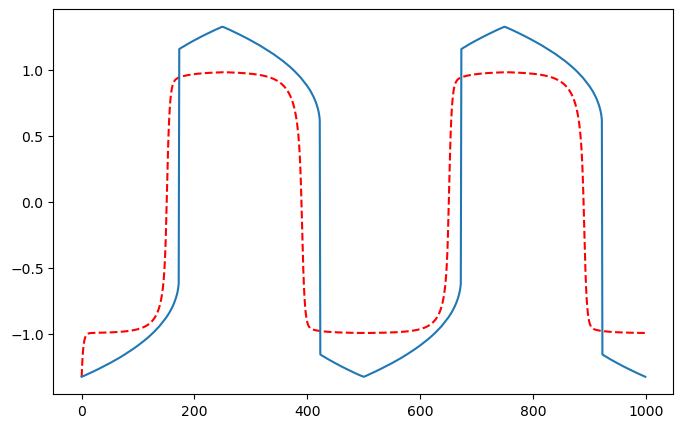

In [24]:


x_pred = odeint(lambda t, x: ode_model(t,x,lam_func), x0, t_span,method='rk4')


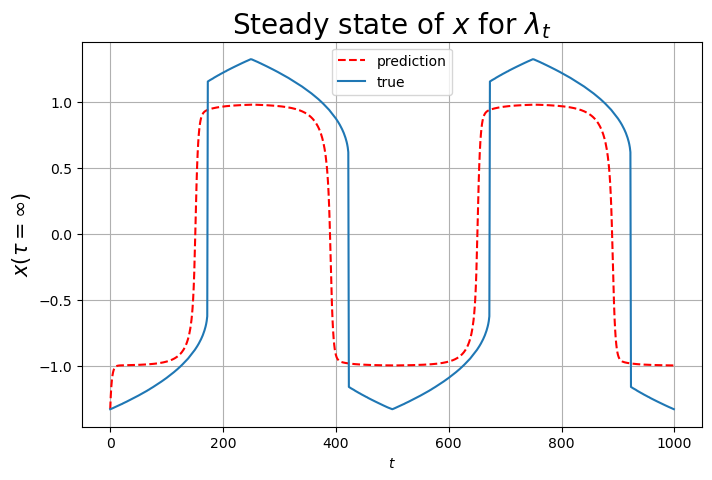

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,5))


ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red', label='prediction')
ax.plot(x_true.squeeze().detach().cpu().numpy(),label='true')
ax.set_xlabel(r'$t$',size=10)
ax.set_ylabel(r'$x(\tau=\infty)$',size=15)
ax.set_title(r"Steady state of $x$ for $\lambda_t$", size=20)
ax.grid(True)
ax.legend()
plt.savefig("epochs_10.png")
plt.show()

### save results

In [40]:
f_cpu = f.to('cpu')
g_cpu = g.to('cpu')
ode_model_cpu = ODEModel(f_cpu, g_cpu)

In [41]:
save_path = "full_gd_lr_01_epoch_10.pt"

torch.save({"f_state_dict": f_cpu.state_dict(),
           "g_state_dict": g_cpu.state_dict(),
           "ode_model_state_dict": ode_model_cpu.state_dict()}, save_path)

f.to(device)
g.to(device)

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [45]:
g

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [77]:
def g_true(x,lam):
    return (1/x)*(lam/x+1)

In [94]:
g.eval()

g_out = []
g_true_out = []
for idx in range(len(x_true)):
    xi = x_true[idx]
    xi = torch.tensor([[xi]],dtype =torch.float32,device=device)

    lami = lam_vals[idx]
    lami = torch.tensor([[lami]],dtype=torch.float32,device=device)

    with torch.no_grad():
        g_out.append(g(xi,lami).detach().cpu().numpy())

    g_true_out.append(g_true(xi,lami).detach().cpu().numpy())
    

In [95]:
g_out = np.array(g_out).reshape(-1)

In [96]:
g_true_out = np.array(g_true_out).reshape(-1)
g_true_out.shape

(1000,)

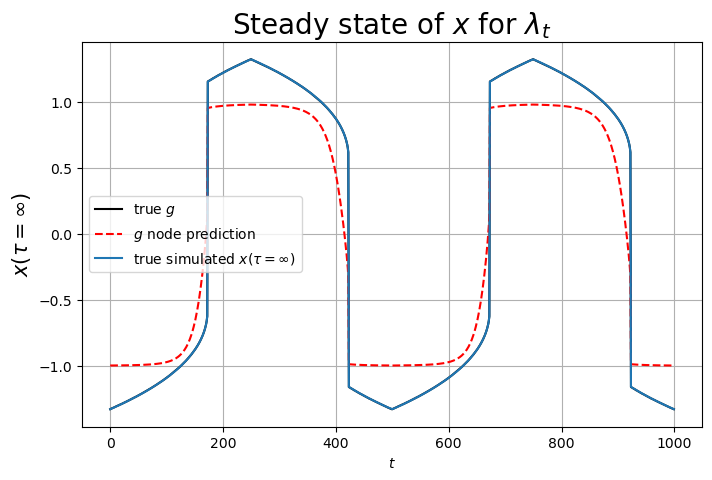

In [110]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(g_true_out,c='black', label=r'true $g$')
ax.plot(t_span.detach().cpu().numpy(),g_out,c='red', linestyle="--", label=r"$g$ node prediction")
ax.plot(x_true.squeeze().detach().cpu().numpy(),label=r'true simulated $x(\tau=\infty)$')
# ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red', label='prediction')

ax.set_xlabel(r'$t$',size=10)
ax.set_ylabel(r'$x(\tau=\infty)$',size=15)
ax.set_title(r"Steady state of $x$ for $\lambda_t$", size=20)
ax.grid(True)
ax.legend()
plt.savefig("epochs_10.png")

plt.show()